In [1]:
DEBUG = False

In [2]:
import logging
import sys
import os


logger = logging.getLogger('eva;_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - [%(filename)s:%(lineno)d] - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

### TODO:
- [ ] add consolidated tags metric
- [ ] calculate matrix delta average
- [ ] remove headers from metric

In [3]:
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [4]:
if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
 

In [5]:
import analyser.hyperparams


Nemoware Analyser v23.3.6
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


In [6]:
import mlflow
# mlflow.start_run(run_name='fetch trainset from db')
ml_flow_url = os.environ.get('MLFLOW_URL', "http://192.168.10.38:5000")
mlflow.set_tracking_uri(ml_flow_url)
print(f'{ml_flow_url=}', 'set MLFLOW_URL env var to re-define')

mlflow.set_experiment("Обучение анализатора")
active_mlflow_run = mlflow.start_run(nested=True)

ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define


# Imports

In [7]:
%matplotlib inline

 
import numpy as np
import pandas as pd

from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag

from analyser.contract_parser import nn_get_tag_values
from analyser.contract_parser import nn_find_org_names, nn_get_subject, nn_get_contract_number, nn_get_contract_date
from analyser.parsing import AuditContext


from tf_support.tf_subject_model import decode_subj_prediction
from integration.db import get_doc_by_id
from bson import ObjectId
 
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager
from tf_support.super_contract_model import semantic_map_keys_contract



HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


2023-03-10 21:29:31.425822: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [8]:
from colab_support.renderer import HtmlRenderer
import matplotlib as matplotlib

from IPython.core.display import display, HTML

class DemoRenderer(HtmlRenderer):
  def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    html = self.to_color_text(tokens, weights, colormap, print_debug, _range, separator=separator)
    display(HTML(html))

  def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    return super()._to_color_text(tokens, weights, matplotlib, colormap=colormap, _range=_range, separator=separator)

renderer_ = DemoRenderer()


# renderer_.render_color_text(["слово 1", "слово 2"], np.array( [1, 0]), _range=(0,1))

/tmp/ipykernel_1935427/530718550.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Prepare paths


In [9]:
from pathlib import Path
work_dir = Path(analyser.hyperparams.work_dir)
# del work_dir
# # print(work_dir)

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'
print(f'{training_reports_path=}')
print(f'{analyser.hyperparams.work_dir=}')
print(f'{work_dir=}')

training_reports_path=PosixPath('/root/artem/analyser/training_reports')
analyser.hyperparams.work_dir='/root/artem/work'
work_dir=PosixPath('/root/artem/work')


# Loading data set meta

In [10]:
umtm = UberModelTrainsetManager (work_dir, training_reports_path)
umtm.load_contract_trainset_meta()
stats = umtm.stats
stats['sample_weight']=-1.0 #TODO: WHY?
stats['subject_weight']=-1.0
stats

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject_pos,org-1-type,org-2-type,url,unseen,score,hash,dups,subject_weight,sample_weight
_id,,,,,,,,,,,,,,,,,,,,,
5e587dce99b345c81a70340d,file,c7638957131b716a710dcb357e4dc198,1.12.0,2023-03-06 14:57:59.719721,5950.0,2020-06-16 18:33:25.117000+00:00,9.900000e+08,20.713216,724.0,RUB,...,NaN,Общество с ограниченной ответственностью,публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5e58...,False,2.011307e-01,-3.676084e+18,1.0,-1.0,-1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-03-06 14:58:02.840701,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,NaN,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.091754e-01,4.114182e+18,1.0,-1.0,-1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,1444.0,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.169281e-01,-2.326586e+18,1.0,-1.0,-1.0
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4890.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,6.763288e-01,-3.199301e+18,4.0,-1.0,-1.0
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3130.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,148.0,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,7.102020e-01,-2.951830e+18,2.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63ce4a02e83d1ee490f3f2cd,db,395c9274717cf6052faa2348baa2f4c5,23.01.23,2023-03-02 18:17:42.175010,90.0,2023-01-24 17:25:11.981000+00:00,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07,-6.176643e+18,1.0,-1.0,-1.0
63c506d5e2456d59975e1389,db,2628dbfa46813bc351104e1ebdc6d6a2,23.01.04,2023-03-02 18:17:32.130682,2170.0,2023-01-16 11:21:48.816000+00:00,NaN,NaN,NaN,NaN,...,318.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,6.665437e+07,-9.401634e+17,1.0,-1.0,-1.0
63ce4a7ce83d1ee490f3f9e4,db,b0e10d1baad50f80a892c135e8b0d31c,23.01.23,2023-03-02 18:17:44.323394,550.0,2023-01-25 08:08:48.990000+00:00,NaN,NaN,NaN,NaN,...,252.0,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07,9.065782e+17,1.0,-1.0,-1.0


## Validate trainset (take a sample)

In [11]:
from tf_support.super_contract_model import  validate_datapoint

# stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

ERROR - 2023-03-10 21:29:38,247 - [1716990915.py:12] - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e51bd24992aa3104108-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:29:38,250 - [1716990915.py:12] - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e50bd24992aa31040f2-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:29:38,641 - [1716990915.py:12] - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e51bd24992aa3104122-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:29:39,476 - [1716990915.py:12] - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/5feb3e50bd24992aa31040e1-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:29:42,266 - [1716990915.py:12] - eva;_ipynb - [Errno 2] No such file or directory: '/root/artem/work/datasets/63c506d0e2456d59975e1327-datapoint-embeddings.npy'
ERROR - 2023-03-10 21:29:42,405 - [1716990915.py:12] - eva;_ipynb - [Errno 2] No such

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-type,org-2-type,url,unseen,score,hash,dups,subject_weight,sample_weight,error
_id,,,,,,,,,,,,,,,,,,,,,
5e587dce99b345c81a70340d,file,c7638957131b716a710dcb357e4dc198,1.12.0,2023-03-06 14:57:59.719721,5950.0,2020-06-16 18:33:25.117000+00:00,9.900000e+08,20.713216,724.0,RUB,...,Общество с ограниченной ответственностью,публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/5e58...,False,2.011307e-01,-3.676084e+18,1.0,-1.0,-1.0,None
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-03-06 14:58:02.840701,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.091754e-01,4.114182e+18,1.0,-1.0,-1.0,None
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.169281e-01,-2.326586e+18,1.0,-1.0,-1.0,None
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4890.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,6.763288e-01,-3.199301e+18,4.0,-1.0,-1.0,None
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3130.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,7.102020e-01,-2.951830e+18,2.0,-1.0,-1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63ce4a02e83d1ee490f3f2cd,db,395c9274717cf6052faa2348baa2f4c5,23.01.23,2023-03-02 18:17:42.175010,90.0,2023-01-24 17:25:11.981000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07,-6.176643e+18,1.0,-1.0,-1.0,[Errno 2] No such file or directory: '/root/ar...
63c506d5e2456d59975e1389,db,2628dbfa46813bc351104e1ebdc6d6a2,23.01.04,2023-03-02 18:17:32.130682,2170.0,2023-01-16 11:21:48.816000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,6.665437e+07,-9.401634e+17,1.0,-1.0,-1.0,None
63ce4a7ce83d1ee490f3f9e4,db,b0e10d1baad50f80a892c135e8b0d31c,23.01.23,2023-03-02 18:17:44.323394,550.0,2023-01-25 08:08:48.990000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.665437e+07,9.065782e+17,1.0,-1.0,-1.0,None


In [12]:
stats_valid = stats[stats['valid']]
# stats_valid = stats_valid[stats_valid.source=='file']
len(stats_valid)

2055

In [13]:
import json
import re
from bson import json_util

fn = work_dir / 'documents.json'
with open(fn) as file:
    file_data = json.load(file, object_hook=json_util.object_hook)    
    print(f'total docs in {fn} is {len(file_data)}')    
    

total docs in /root/artem/work/documents.json is 622


## validating data set

In [14]:

def validate_datapoint(id: str, meta: DataFrame):
  try:
    (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(id, meta)
    if sm.shape[1] != len(semantic_map_keys_contract):
      mxs = f'semantic map shape is {sm.shape[1]}, expected is {len(semantic_map_keys_contract)} source={meta.at[id, "source"]}'
      raise ValueError(mxs)

  except Exception as e:
    raise e
    
# validate_datapoint('5deba9034ddc27bcf92dd383', stats)

In [15]:
if DEBUG:

    def test_date_tags_detector(doc_id):

        try:
            jd = DbJsonDoc(get_doc_by_id(ObjectId(doc_id)))


            (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(doc_id, stats)
            sm = pd.DataFrame( sm, columns= semantic_map_keys_contract) 

            user_date_val = jd.user['attributes_tree']['contract']['date']            
            date_tag_____ = nn_get_contract_date     (jd.get_tokens_map_unchaged(), sm)

            if date_tag_____.value != user_date_val['value']:

                print(f"{date_tag_____.span=}\t\t{date_tag_____.value=} ")

                print(f"{user_date_val['span']=}\t\t{user_date_val['value']=}")
                print(f"{date_tag_____.value == user_date_val['value']}")
                print(doc_id, '_'*50)
        except:
            pass
    #         print(doc_id, 'no date')

    for k in range(0,len(stats[stats.source=='db'])):
        test_date_tags_detector(stats[stats.source=='db'].index[k])

In [16]:
from analyser.persistence import DbJsonDoc
from tf_support.super_contract_model import make_xyw

import traceback

docs = {}
errors = 0
for fd in file_data:
    try:
      validate_datapoint(str(fd['_id']), stats)
      docs [fd['_id']] =  DbJsonDoc(fd)
#       print (fd['_id'])
    except KeyError as e:
      errors += 1
      logger.error(f'No key in stats: {str(e)}')
    except Exception as e:
      errors += 1
      
      logger.error(f'{type(e)}, {str(e)}')
      traceback.print_exc()

print('errors count:', errors)
print(f'total docs in {fn} is {len(list(docs.values()))}')   

ERROR - 2023-03-10 21:29:56,506 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5dece9b94ddc27bcf92dd409'
ERROR - 2023-03-10 21:29:56,508 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5dece9be4ddc27bcf92dd410'
ERROR - 2023-03-10 21:29:56,511 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5dece9be4ddc27bcf92dd411'
ERROR - 2023-03-10 21:29:56,521 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5dece9bf4ddc27bcf92dd41b'
ERROR - 2023-03-10 21:29:56,524 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5dece9c14ddc27bcf92dd42b'
ERROR - 2023-03-10 21:29:56,562 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded004f4ddc27bcf92dd490'
ERROR - 2023-03-10 21:29:56,570 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded06f04ddc27bcf92dd4b0'
ERROR - 2023-03-10 21:29:56,587 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded07184ddc27bcf92dd4eb'
ERROR - 2023-03-10 21:29:56,590 - [2235134416.py:15] - eva;_ipynb - No key in stats: '5ded07184ddc27bcf9

errors count: 76
total docs in /root/artem/work/documents.json is 546


## Get sample doc (DEBUG)

In [17]:
if DEBUG:
    a_doc_from_json = list(docs.values())[1]
    print(a_doc_from_json.get_tokens_map_unchaged().text[:230])
    
    a_doc_from_json.get_attributes_tree()

In [18]:
%matplotlib inline


from colab_support.renderer import plot_embedding, plot_cm
from tf_support.super_contract_model import make_xyw

if DEBUG:
    SAMPLE_DOC_ID = str(a_doc_from_json.get_id())# stats_valid.index[0]


    # SAMPLE_DOC_ID = '5fdb2145542ce403c92b460c'
    # del a_doc_from_json

    print(f'{SAMPLE_DOC_ID=}')

    (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)


    print(f'semantic map shape {sm.shape=}')
    _crop = 700
    plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
    plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
    plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')

# Init Model 🦖

In [19]:
if 'TEST_FLOW' not in globals():
    TEST_FLOW = False
print(f'{TEST_FLOW=}')

TEST_FLOW=False


In [20]:

if 'model_factory_fn' in globals():
    print ('*'*80)
    print('model_factory_fn defined as', model_factory_fn.__name__)
else:
    from tf_support.super_contract_model import make_att_model
    model_factory_fn = make_att_model

print(f'{model_factory_fn=}')

model_factory_fn=<function make_att_model_03 at 0x7f1735419c10>


In [21]:
# x


see https://mlflow.org/docs/latest/models.html#keras-keras

In [22]:
import mlflow
from tf_support.tools import KerasTrainingContext

 
ctx = KerasTrainingContext(umtm.work_dir, session_index=21)
ctx.EVALUATE_ONLY = True
 
    
if 'umodel' in globals() and umodel is not None:
    print ('*'*80)
    print('umodel defined as', umodel.name)
else:
    # weights = Path(analyser.hyperparams.models_path) / f"{model_factory_fn.__name__}.h5"
    weights = training_reports_path / f'{model_factory_fn.__name__}.h5'
    mlflow.log_param('weights', str(weights))
    if weights.is_file():
        print (f'LOADING: {model_factory_fn} -- {weights}')
    
    
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
    mlflow.log_param('model_name', str(umodel.name))
    mlflow.log_param('model_params', umodel.count_params())
    
    
umodel.trainable = False
umodel.summary()

[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/work
2023-03-10 21:29:58.719300: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-10 21:29:59.239654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 21:29:59.240311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-10 21:29:59.240333: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-10 21:29:59.240369: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcub

LOADING: <function make_att_model_03 at 0x7f1735419c10> -- /root/artem/analyser/training_reports/make_att_model_03.h5


 had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 21:29:59.299903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-03-10 21:29:59.300263: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 21:29:59.300767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 21:29:59.301641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMe

Model: "make_att_model_03"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb_norm (LayerNorma (None, None, 1024)   2048        input_text_emb[0][0]             
__________________________________________________________________________________________________
token_features_norm (LayerNorma (None, None, 15)     30          token_features[0][0]             
__________________________________________________________________________________

In [23]:
# analyser.hyperparams.__dict__

## Restore model from MLFLOW

In [24]:
import mlflow
from pathlib import Path

# from mlflow.models import Model
# umodel = mlflow.tensorflow.load_model("runs:/d31c40c014364832a9895b5fb30428ae/model")
# umodel.summary()

# umodel.save_weights(Path(analyser.hyperparams.models_path) / (umodel.name + ".h5"))



## Blend  2 models

In [25]:
# # Now - create a new averaged weights:

# new_weights = np.array(list())
if False:
    resources =  ['runs:/42802c6790a1431c838bbceb891445f6/model', 'runs:/7f26cfaa557c4cbba727cca3b8fb5e1c/model']

    weights = [mlflow.tensorflow.load_model(r).get_weights() for r in resources]

    new_weights = list()
    for weights_list_tuple in zip(*weights): 
        new_weights.append(
            np.array([np.array(w).mean(axis=0) for w in zip(*weights_list_tuple)])
        )


    # for weights_list_tuple in zip(*weights):
    #     new_weights.append(
    #         [np.array(weights_).mean(axis=0)\
    #             for weights_ in zip(*weights_list_tuple)])

    # And what is left is to set these weights in a new model:

    # new_model.set_weights(new_weights)
    
    umodel.set_weights(np.array(new_weights))
    
    mlflow.end_run()
    mlflow.start_run(nested=False, run_name='blend of 2 weights')

    # mlflow.log_artifact(umodel)
    mlflow.tensorflow.log_model(model = umodel, artifact_path='tf-model-blend')
    # , artifact_path=str(Path(analyser.hyperparams.models_path) / (umodel.name + ".blend.h5"))

    mlflow.end_run()
    
   

In [26]:
# umodel.save_weights(Path(analyser.hyperparams.models_path) / (umodel.name + ".blend.h5"))

# Functions replacements (TMP)

In [27]:
# import datetime
 
# if True:
 

#     def nn_get_contract_date(textmap: TextMap, semantic_map: DataFrame) -> SemanticTag:
#       tag_name = 'date'
#       date_index = semantic_map[f'{tag_name}-begin'].argmax()
#       confidence = float(semantic_map[f'{tag_name}-begin'][date_index])
#       sentense_span = textmap.sentence_at_index(date_index)
#       date_sentence = textmap.text_range(sentense_span)
    
# #       print(f'{date_sentence=}')

#       _charspan, dt = find_date(date_sentence)
#       if dt is not None and confidence > 0.01:#TODO:
#         region_map = TextMap(date_sentence)
#         span = region_map.token_indices_by_char_range(_charspan)
#         tag = SemanticTag(tag_name, dt, span)
#         tag.confidence = confidence
#         return tag
#       return None
            
# #       tags = nn_get_tag_values('date', textmap, semantic_map, max_tokens=6, threshold=0.3, limit=1)
    
# #       if tags:
# #         tag = tags[0]
# #         _, dt = find_date(tag.value)
# #         tag.value = dt
# #         if dt is not None:
# #           return tag

# # del find_date
# from analyser.doc_dates import find_date
# # s='1 января 2014 года'
# s = 'ДОГОВОР № 43/09-2020 на изготовление печатных агитационных материалов г. Ноябрьск «21» августа 2020 год.'
# find_date(s)


# Evaluate models

## Evaluate single doc (self-test)

In [28]:
# sample_index = umtm.stats [umtm.stats['value']>0].index[2]
if DEBUG:
    print(f'{SAMPLE_DOC_ID=}')
    prediction = umodel.predict(x=[np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)], batch_size=1)


    tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
    tagsmap_e = pd.DataFrame(sm, columns=semantic_map_keys_contract)
    delta = tagsmap - tagsmap_e 
    # .T
    plot_embedding(tagsmap[:_crop], f'Predicted Semantic Map {tagsmap.shape}')
    plot_embedding(delta[:_crop], title=f'DELTA Semantic map {tagsmap_e.shape}')
    plot_embedding(tagsmap_e[:_crop], title=f'EXPECTED Semantic map {tagsmap_e.shape}')

In [29]:
if DEBUG:
    print("mean delta", delta.abs().sum().sum() / tagsmap_e.sum().sum())
    print("sum of delatas", delta.abs().sum().sum())

In [30]:
if DEBUG:
    av = tagsmap.max(axis=1) #tagsmap['amount-begin'] + tagsmap['vat-begin'] + tagsmap['number-begin'] + tagsmap['org-name-begin']

    # av = tagsmap.sum(axis=1)
    renderer_.render_color_text(a_doc_from_json.get_tokens_map_unchaged().tokens[:600], av[:600])

### Getting tag values from inferred semantic map

In [31]:
ac = AuditContext()

#### Orgs

In [32]:
if DEBUG:
    cas = nn_find_org_names(a_doc_from_json.get_tokens_map_unchaged(), tagsmap, ac)
    if cas:
        if len(cas)>0:

            print(cas[0].name)
            print(cas[0].type)
            print(cas[0].alias)
        if len(cas)>1:
            print()
            print(cas[1].name)
            print(cas[1].type)
            print(cas[1].alias)

#### Date/number

In [33]:
if DEBUG:
    date_tag = nn_get_contract_date     (a_doc_from_json.get_tokens_map_unchaged(), tagsmap) 
    number_tag = nn_get_contract_number (a_doc_from_json.get_tokens_map_unchaged(), tagsmap)
    if date_tag:
        print( f'{date_tag.value=}')
    if number_tag:
        print( f'{number_tag.value=}' )
    
if DEBUG:
    attention = tagsmap['date' + '-begin'].values.copy()

    threshold = max(attention.max() * 0.8, 0.1)
    print(f'{attention.max()=}')

#### Amount

In [34]:
if DEBUG:
    textmap = a_doc_from_json.get_tokens_map_unchaged()

In [35]:
from pandas import DataFrame
from analyser.schemas import ContractPrice, merge_spans
from analyser.legal_docs import find_value_sign
from analyser.transaction_values import ValueSpansFinder
from analyser.text_tools import to_float
from analyser.contract_parser import nn_find_contract_value
if DEBUG:
    #---
    cps = nn_find_contract_value(textmap, tagsmap)
    if cps:
      print(str(cps[0].get_span()))
      for k in cps[0].list_children():
        print(str(k))

      print()
      print()

      print('brutto', str(cps[0].amount_brutto))
      print('netto', str(cps[0].amount_netto))
      print('amount', str(cps[0].amount))
      print('vat', str(cps[0].vat))
    else:
      print('nothing found')

#### Miscl.

In [36]:
if DEBUG:
    thresholds = dict(tagsmap.max()*.8)
    thresholds

#### Subj

In [37]:
if DEBUG:
    subject_tag = nn_get_tag_values('subject',  a_doc_from_json.get_tokens_map_unchaged(), tagsmap, max_tokens=200, threshold=0.02, limit=1, return_single=True)

    print(subject_tag)

### Draw tags TODO:

In [38]:
import matplotlib.pyplot as plt

if DEBUG:
    tags_hl = np.zeros(len(textmap))


# def hl(tag):
#   try:
#     tags_hl [ tag.span[0]:tag.span[1]] +=1
#   except:
#     pass
  

# if cps:
#   hl(cps[0].amount_brutto)
#   hl(cps[0].amount_netto)
#   hl(cps[0].amount)
#   hl(cps[0].vat)
#   hl(cps[0].sign)
#   hl(cps[0].currency)
#   hl(cps[0])


# if cas and len(cas)>0:
#     hl(cas[0].name)
#     hl(cas[0].type)
#     hl(cas[0].alias)

    
# if cas and len(cas)>1:
#     hl(cas[1].name)
#     hl(cas[1].type)
#     hl(cas[1].alias)

# hl(number_tag)
# hl(date_tag)


# hl(subject_tag)

# renderer_.render_color_text(a_doc_from_json.get_tokens_map_unchaged().tokens[:160], tags_hl[:160])

# Reporting

In [39]:
ev =   umtm.stats.copy()
tags =          pd.DataFrame()
errors_report = pd.DataFrame()


In [40]:
userdocs = umtm.stats[umtm.stats.unseen==False]
userdocs = userdocs[userdocs.source=='db']
userdocs = userdocs[userdocs.score < 50000]
userdocs = userdocs[userdocs['valid']==True]

userdocs

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-type,org-2-type,url,unseen,score,hash,dups,subject_weight,sample_weight,error
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,Общество с ограниченной ответственностью,компания,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,0.616928,-2.326586e+18,1.0,-1.0,-1.0,None
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4890.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,0.676329,-3.199301e+18,4.0,-1.0,-1.0,None
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3130.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,0.710202,-2.951830e+18,2.0,-1.0,-1.0,None
63908ca4a1bded13e629f2e9,db,daa1fec657ec24b7314d0ef2d3a9f411,23.01.23,2023-03-02 18:17:29.357107,3130.0,2023-01-27 16:02:07.552000+00:00,5.000000e+09,22.332704,412.0,RUB,...,Публичное акционерное общество,Публичное акционерное общество,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,0.746182,-5.154901e+17,1.0,-1.0,-1.0,None
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-03-02 18:17:44.744332,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,Акционерное общество,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,0.753434,3.376575e+18,1.0,-1.0,-1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fe4821db770574a005556de,db,38994dcd4a043737bcdd192a4a7628f9,2.3.13,2023-03-02 18:17:03.088617,1470.0,2020-12-24 17:20:24.330000+00:00,NaN,NaN,NaN,NaN,...,Общество с ограниченной ответственностью,Кандидат в депутаты,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,False,40338.437423,-3.044189e+18,1.0,-1.0,-1.0,None
5fbbe469a2b4551c06107b84,db,3e105cde7eeaf549084d72610472501c,2.0.5,2023-03-02 18:16:45.846257,3130.0,2020-11-24 08:26:51.052000+00:00,NaN,NaN,NaN,NaN,...,Акционерное общество,Зарегистрированный кандидат в депутаты Городск...,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,False,40338.437423,7.033672e+18,1.0,-1.0,-1.0,None
5fe4821fb770574a0055575a,db,e72bf248aad41d813ec43dee2e030063,2.3.13,2023-03-02 18:17:03.361231,1610.0,2020-12-24 17:53:40.209000+00:00,NaN,NaN,NaN,NaN,...,Общество с ограниченной ответственностью,Общество с ограниченной ответственностью,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,False,41082.800250,-2.196851e+18,1.0,-1.0,-1.0,None


In [41]:
from tf_support.super_contract_model import t_semantic_map_keys_price, semantic_map_keys, t_semantic_map_keys_common, t_semantic_map_keys_org
semantic_keys_numeric = ['amount', 'amount_brutto', 'amount_netto']

In [42]:

for v in semantic_map_keys:
    for s in ['_expected', '_predicted']:
        userdocs[f'{v}{s}'] = ''
        userdocs[f'{v}{s}'] = userdocs[f'{v}{s}'].astype(str)
        
for v in semantic_keys_numeric:
    for s in ['_expected', '_predicted']:
        userdocs[f'{v}{s}'] = np.NaN
        userdocs[f'{v}{s}'] = userdocs[f'{v}{s}'].astype(float)
        


In [43]:
org_keys=['name', 'alias', 'type']
org_numbered_keys=[ f'org-1-{v}' for v in org_keys]
org_numbered_keys+=[ f'org-2-{v}' for v in org_keys]
org_numbered_keys

['org-1-name',
 'org-1-alias',
 'org-1-type',
 'org-2-name',
 'org-2-alias',
 'org-2-type']

In [44]:
from analyser.text_tools import to_float, span_len

def fix_contract_number(tag: SemanticTag, textmap: TextMap) -> SemanticTag or None:
  if tag:
    span = [tag.span[0], tag.span[1]]
    for i in range(tag.span[0], tag.span[1]):
      if i < 0 or i >= len(textmap):
        msg = f'{i=} {textmap=} {len(textmap)=} {tag=} {tag.span=}'
        logger.error(msg)
        raise ValueError(msg)

      t = textmap[i]
      t = t.strip().lstrip('№').lstrip().lstrip(':').lstrip('N ').lstrip().rstrip('.')
      if t == '':
        span[0] = i + 1
    tag.span = span
  if span_len(tag.span) == 0:
    return None

  return tag

In [45]:
128*12

1536

In [46]:
batch_size = 96
maxlen = 128*12

analyser.contract_parser.fix_contract_number=fix_contract_number
 
def load_doc_as_table_row(_id, df, col_suffix='_expected'):
    doc = get_doc_by_id(ObjectId(_id))
    if doc is None:
        print (f'{_id} not found in db')
        return
    
    jd = DbJsonDoc(doc)
#     print(jd.get_attribute_value('number'))
#     df.at[ _id, f'analyze_timestamp{col_suffix}']=jd.analysis['analyze_timestamp']
    
    tree = jd.get_attributes_tree()
    df.at[ _id, f'number{col_suffix}'] = jd.get_attribute_value('number')
    df.at[ _id, f'date{col_suffix}']   = jd.get_attribute_value('date')
    df.at[ _id, f'subject{col_suffix}']= jd.get_attribute_value('subject')
    
    orgs = tree.get('orgs', [])
#     for i, o in enumerate(orgs):
    if len(orgs)>0:
        o1=orgs[0]
    else:
        o1={}
        
    if len(orgs)>1:
        o2=orgs[1]
    else:
        o2={}
        
    for part in org_keys:
        v1 = o1.get(part, {}).get('value', "").lower()
        v2 = o2.get(part, {}).get('value', "").lower()
        vv=sorted([v1,v2])
        df.at[ _id, f'org-1-{part}{col_suffix}'] = vv[1]
        df.at[ _id, f'org-2-{part}{col_suffix}'] = vv[0]

    
    for v in t_semantic_map_keys_price:
        df.at[ _id, f'{v}{col_suffix}'] =  tree.get('price', {}).get(v, {}).get('value')

    df.at[ _id, f'analysis.version{col_suffix}'] = jd.analysis['version']
    return jd
    
    
    
    
def interpret_prediction(_id, tagsmap, df):
    col_suffix="_predicted"
    
    doc = load_doc_as_table_row(_id, df)
    if doc is None: 
        return
    
    tokens = doc.get_tokens_map_unchaged()
    
    #---
    # ORGS ------------------
    orgs = nn_find_org_names(tokens, tagsmap, ac)
    if len(orgs)>0:
        o1 = orgs[0]
    else:
        o1={}
        
    if len(orgs)>1:
        o2 = orgs[1]
    else:
        o2={}
        
    for part in ['name', 'alias', 'type']:
        part_tag1 = getattr(o1, part, {})
        part_tag2 = getattr(o2, part, {})
        
        v1 = getattr(part_tag1, 'value', '').lower()
        v2 = getattr(part_tag2, 'value', '').lower()
#         vv= [v1,v2]
        vv=sorted([v1,v2])
        df.at[ _id, f'org-1-{part}{col_suffix}'] = vv[1] 
        df.at[ _id, f'org-2-{part}{col_suffix}'] = vv[0] 
 
    # PRICE ------------------
    cps = nn_find_contract_value(tokens, tagsmap)
    if cps:
        cps=cps[0]
        for v in t_semantic_map_keys_price:
            part = getattr(cps, v)
            if part:
                df.at[ _id, f'{v}{col_suffix}'] = part.value
                 
 
    # DATE NUMBER ------------------
    number_tag = nn_get_contract_number(tokens, tagsmap)
    date_tag =   nn_get_contract_date  (tokens, tagsmap) 
    
        
    if number_tag:
        df.at[ _id, f'number{col_suffix}'] = str(number_tag.value)
    else:
        df.at[ _id, f'number{col_suffix}'] = ''
        
        
    if date_tag:
        df.at[ _id, f'date{col_suffix}'] = str(date_tag.value)
    else:
        df.at[ _id, f'date{col_suffix}'] = ''
 

validation_set = userdocs
if TEST_FLOW:
    validation_set = userdocs[0:20]

    
    
for i in range(0, len(validation_set), batch_size):
    batch = userdocs[i:i+batch_size]
    actual_batch_size=len(batch)
    print(f'{actual_batch_size=}')
    batch_input_emb=[]
    batch_input_token_f=[]
    for _id in batch.index.values:
 
        dp = make_xyw(_id, userdocs)
        dp = umtm.trim_maxlen( dp, 0, maxlen  )
        (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

        batch_input_emb.append(emb)
        batch_input_token_f.append(tok_f)
        
        expected_subj =  decode_subj_prediction(subj)[0]
        userdocs.at[_id, 'subject_expected'] = expected_subj.name
 
        # weights_subj.append(subject_weight)

    del _id
    del dp

    
    
    dps =  [np.array(batch_input_emb), np.array(batch_input_token_f)]
 
    
    predictions = umodel.predict(x=dps, batch_size=actual_batch_size)
    del batch_input_emb
    del batch_input_token_f
#     print ('len(predictions)', len(predictions))
    
    p_tags = predictions[0]
    p_subj = predictions[1]
    for k,_id in enumerate(batch.index.values):
#     for k in range(0, len(p_tags)):
#         print (k, p_tags.shape, p_subj.shape)
                   
        tagsmap = pd.DataFrame(p_tags[k], columns=semantic_map_keys_contract)
        interpret_prediction(_id, tagsmap, userdocs)
        
        subj_1hot = p_subj[k]

#         expected =  decode_subj_prediction(subj[k])
        predicted = decode_subj_prediction(subj_1hot)[0]
        userdocs.at[_id, 'subject_predicted'] = predicted.name
        
        
#         print(predicted)
            
#         print(_id, trim_dp(x[0]).shape)

# userdocs[['org-1-name_expected','subject_expected','subject_predicted','date_expected','date_predicted', 'number_expected','number_predicted']].head(30)
userdocs[
  ['org-1-type_expected', 'org-1-type_predicted', 'org-1-name_expected', 'org-1-name_predicted', 'org-1-alias_expected', 'org-1-alias_predicted', 
   'org-2-type_expected', 'org-2-type_predicted', 'org-2-name_expected', 'org-2-name_predicted', 'org-2-alias_expected', 'org-2-alias_predicted', 
   'subject_expected', 'subject_predicted', 'date_expected',
   'date_predicted', 'number_expected', 'number_predicted']].head(30)




actual_batch_size=96


2023-03-10 21:30:02.089822: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-10 21:30:02.109946: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2023-03-10 21:30:02.979322: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-10 21:30:04.362984: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-03-10 21:30:04.710329: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-10 21:30:04.710655: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-10 21:30:04.710675: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
/root/artem/analyser

DB HOST IS: 192.168.10.36


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f17130ebfd0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f17130ebf70>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/a

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f17130c3070>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object


actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f1712afda00>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f1712afd940>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/a

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f1711d11f10>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f1714b5c670>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/a

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f17130eb190>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f1714a83a30>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/a

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f1734c01bb0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f1714d456a0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/a

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f16bc3d0130>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f16bc3d0a90>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/a

actual_batch_size=96


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f16bc4295b0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f16bc429eb0>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/a

actual_batch_size=87


[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f16bc366d90>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/artem/analyser/analyser/transaction_values.py", line 144, in __init__
    self.number_span, self.value, self.currency_span, self.currencly_name, self.including_vat, self.original_sum, self.vat = find_value_spans(
TypeError: cannot unpack non-iterable NoneType object
[contract_parser.py:408 - nn_find_contract_value() ] cannot unpack non-iterable NoneType object
[contract_parser.py:407 - nn_find_contract_value() ] smthinf wrong str(cp)='<analyser.schemas.ContractPrice object at 0x7f1714b81a90>'
Traceback (most recent call last):
  File "/root/artem/analyser/analyser/contract_parser.py", line 389, in nn_find_contract_value
    results = ValueSpansFinder(region)
  File "/root/a

,org-1-type_expected,org-1-type_predicted,org-1-name_expected,org-1-name_predicted,org-1-alias_expected,org-1-alias_predicted,org-2-type_expected,org-2-type_predicted,org-2-name_expected,org-2-name_predicted,org-2-alias_expected,org-2-alias_predicted,subject_expected,subject_predicted,date_expected,date_predicted,number_expected,number_predicted
_id,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,общество с ограниченной ответственностью,общество с ограниченной ответственностью,газпромнефть научно-технический центр,газпромнефть нтц,гпн,гпн,компания,,sun,sun,sun,sun,Service,Service,None,,B1671779,B1671779 Номер
63908ca3a1bded13e629f2dc,публичное акционерное общество,публичное акционерное общество,сбербанк россии,сбербанк,поручитель,поручитель,публичное акционерное общество,публичное акционерное общество,газпром нефть,газпром нефть,банк,банк,BankGuarantees,Loans,None,,None,_____
63a43092beaa9eeec65ecb09,публичное акционерное общество,публичное акционерное общество,московский кредитный банк,московский кредитный,поручитель,поручитель,публичное акционерное общество,публичное акционерное общество,газпром нефть,газпром нефть,банк,,BankGuarantees,BankGuarantees,None,,110801/20,110801/20
63908ca4a1bded13e629f2e9,публичное акционерное общество,публичное акционерное общество,московский кредитный банк,московский кредитный,поручитель,поручитель,публичное акционерное общество,публичное акционерное общество,газпром нефть,газпром нефть,банк,,BankGuarantees,BankGuarantees,None,,№ 110801/20,110801/20
63ce49f8e83d1ee490f3f21c,общество с ограниченной ответственностью,общество с ограниченной ответственностью,газпромнефть-каталитические системы,газпромнефть-каталитические системы,приказодатель,приказодатель,акционерное общество,акционерное общество,газпромбанк,газпромбанк,банк,банк,Loans,Loans,None,,IMP/2019/116,IMP/2019/116
63a430a6beaa9eeec65ecb0b,публичное акционерное,публичное акционерное общество,газпромнефть-ннг,газпромнефть-ннг,продавец,покупатель,акционерное,,газпром нефть,газпром нефть,покупатель,,ParticipationInOtherOrganizations,ParticipationInOtherOrganizations,1993-12-24 00:00:00,1993-12-24 00:00:00,None,ДОГОВОР
63908ca4a1bded13e629f2e3,публичное акционерное общество,публичное акционерное общество,газпромнефть-ноябрьскнефтегаз,газпромнефть-ннг,продавец,покупатель,акционерное общество,,газпром нефть,газпром нефть,покупатель,,ParticipationInOtherOrganizations,ParticipationInOtherOrganizations,None,1993-12-24 00:00:00,None,ДОГОВОР
60defc4e95588e4cfb432c28,общество с ограниченной ответственностью,общество с ограниченной ответственностью,газпромнефть-корпоративные продажи,газпромнефть-корпоративные продажи,продавец,продавец,общество с ограниченной ответственностью,общество с ограниченной ответственностью,август,,покупатель,покупатель,RealEstateTransactions,RealEstateTransactions,2018-07-30 00:00:00,2018-07-30 00:00:00,None,______
6391b4771864c6df4d29f332,публичное акционерное общество,публичное акционерное,газпромнефть-ямал,газпром нефть,принципал,гарант,общество с ограниченной ответственностью,,газпром нефть,,гарант,,BankGuarantees,BankGuarantees,None,,None,


In [47]:
userdocs

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-2-alias_expected,org-1-type_expected,org-2-type_expected,analysis.version_expected,org-1-name_predicted,org-2-name_predicted,org-1-alias_predicted,org-2-alias_predicted,org-1-type_predicted,org-2-type_predicted
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-03-02 18:16:30.799761,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,sun,общество с ограниченной ответственностью,компания,1.6.5,газпромнефть нтц,sun,гпн,sun,общество с ограниченной ответственностью,
63908ca3a1bded13e629f2dc,db,778e9604f0dfb6ed01dc05cce32ab2c2,22.12.7,2023-03-02 18:17:31.541520,4890.0,2022-12-08 21:48:02.600000+00:00,7.000000e+09,22.669176,399.0,NaN,...,банк,публичное акционерное общество,публичное акционерное общество,22.12.7,сбербанк,газпром нефть,поручитель,банк,публичное акционерное общество,публичное акционерное общество
63a43092beaa9eeec65ecb09,db,daa1fec657ec24b7314d0ef2d3a9f411,23.3.1,2023-03-02 18:17:46.991970,3130.0,2023-03-01 16:34:31.821000+00:00,1.550000e+10,23.464106,278.0,RUB,...,банк,публичное акционерное общество,публичное акционерное общество,23.3.1,московский кредитный,газпром нефть,поручитель,,публичное акционерное общество,публичное акционерное общество
63908ca4a1bded13e629f2e9,db,daa1fec657ec24b7314d0ef2d3a9f411,23.01.23,2023-03-02 18:17:29.357107,3130.0,2023-01-27 16:02:07.552000+00:00,5.000000e+09,22.332704,412.0,RUB,...,банк,публичное акционерное общество,публичное акционерное общество,23.01.23,московский кредитный,газпром нефть,поручитель,,публичное акционерное общество,публичное акционерное общество
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-03-02 18:17:44.744332,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,банк,общество с ограниченной ответственностью,акционерное общество,23.1.27.1,газпромнефть-каталитические системы,газпромбанк,приказодатель,банк,общество с ограниченной ответственностью,акционерное общество
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fe4821db770574a005556de,db,38994dcd4a043737bcdd192a4a7628f9,2.3.13,2023-03-02 18:17:03.088617,1470.0,2020-12-24 17:20:24.330000+00:00,NaN,NaN,NaN,NaN,...,заказчик,общество с ограниченной ответственностью,кандидат в депутаты,2.3.13,мастерская печати,издательско-полиграфическое предприятие,исполнитель,заказчик,общество с ограниченной ответственностью,кандидат
5fbbe469a2b4551c06107b84,db,3e105cde7eeaf549084d72610472501c,2.0.5,2023-03-02 18:16:45.846257,3130.0,2020-11-24 08:26:51.052000+00:00,NaN,NaN,NaN,NaN,...,заказчик,зарегистрированный кандидат в депутаты городск...,акционерное общество,2.0.5,фоатьевич,арктика медиа,исполнитель,заказчик,зарегистрированный кандидат в депутаты городской,акционерное общество
5fe4821fb770574a0055575a,db,e72bf248aad41d813ec43dee2e030063,2.3.13,2023-03-02 18:17:03.361231,1610.0,2020-12-24 17:53:40.209000+00:00,NaN,NaN,NaN,NaN,...,заказчик,общество с ограниченной ответственностью,общество с ограниченной ответственностью,2.3.13,сувенир-медиа,издательско-полиграфическое предприятие «масте...,поставщик,заказчик,общество с ограниченной ответственностью,общество с ограниченной ответственностью


### Clean predicted/expected values

In [48]:


# userdocs['amount_expected']=userdocs['amount_expected'].replace('',np.NaN).astype(float)
# userdocs['amount_predicted']=userdocs['amount_predicted'].replace('',np.NaN).astype(float)

# userdocs['amount_brutto_predicted'].replace('',np.NaN).astype(float)
# userdocs['amount_brutto_expected'].replace('',np.NaN).astype(float)

columns = []
for v in semantic_keys_numeric:
    for s in ['_expected', '_predicted' ]:
        col = f'{v}{s}'
        userdocs[col] = userdocs[col].replace('',np.NaN).replace(np.NaN, -1).astype(int)
        columns.append(col)
        
userdocs['date_predicted'] = userdocs['date_predicted'].astype(str)        
userdocs['date_expected'] = userdocs['date_expected'].astype(str)        
userdocs[columns]

,amount_expected,amount_predicted,amount_brutto_expected,amount_brutto_predicted,amount_netto_expected,amount_netto_predicted
_id,,,,,,
5ec2b8da665f7603e03b1255,-1,-1,-1,-1,25236322,-1
63908ca3a1bded13e629f2dc,7000000000,-1,-1,-1,-1,-1
63a43092beaa9eeec65ecb09,-1,-1,-1,-1,15500000000,15500000000
63908ca4a1bded13e629f2e9,5000000000,-1,-1,-1,-1,15500000000
63ce49f8e83d1ee490f3f21c,-1,-1,-1,-1,3000000000,3000000000
...,...,...,...,...,...,...
5fe4821db770574a005556de,-1,-1,-1,-1,-1,-1
5fbbe469a2b4551c06107b84,-1,-1,-1,-1,-1,-1
5fe4821fb770574a0055575a,-1,-1,-1,-1,-1,-1


In [49]:
userdocs=userdocs.replace('None', '')
userdocs=userdocs.replace('none', '')
userdocs=userdocs.replace('nan', '')

userdocs.date_expected =  userdocs.date_expected.replace(np.NaN, '')
userdocs.date_predicted = userdocs.date_predicted.replace(np.NaN, '')

userdocs.number_expected =  userdocs.number_expected.replace(np.NaN, '')
userdocs.number_predicted = userdocs.number_predicted.replace(np.NaN, '')

userdocs.vat_unit_expected =  userdocs.vat_unit_expected.replace(np.NaN, '')
userdocs.vat_unit_predicted = userdocs.vat_unit_predicted.replace(np.NaN, '')

userdocs.vat_expected =  userdocs.vat_expected.replace(np.NaN, '')
userdocs.vat_predicted = userdocs.vat_predicted.replace(np.NaN, '')

userdocs.sign_expected =  userdocs.sign_expected.replace(np.NaN, '')
userdocs.sign_predicted = userdocs.sign_predicted.replace(np.NaN, '')

userdocs.currency_expected =  userdocs.currency_expected.replace(np.NaN, '')
userdocs.currency_predicted = userdocs.currency_predicted.replace(np.NaN, '')
userdocs[['date_expected', 'date_predicted', 'number_expected', 'number_predicted']]

,date_expected,date_predicted,number_expected,number_predicted
_id,,,,
5ec2b8da665f7603e03b1255,,,B1671779,B1671779 Номер
63908ca3a1bded13e629f2dc,,,,_____
63a43092beaa9eeec65ecb09,,,110801/20,110801/20
63908ca4a1bded13e629f2e9,,,№ 110801/20,110801/20
63ce49f8e83d1ee490f3f21c,,,IMP/2019/116,IMP/2019/116
...,...,...,...,...
5fe4821db770574a005556de,2020-08-21 00:00:00,2020-08-21 00:00:00,43/09-2020,43/09-2020
5fbbe469a2b4551c06107b84,2019-08-28 00:00:00,2019-08-28 00:00:00,19-35,19-35 Д
5fe4821fb770574a0055575a,2019-12-23 00:00:00,2019-12-23 00:00:00,19-57P,19-57P г


In [50]:
def select_wrong(userdocs, key):
    s= userdocs[userdocs[f'{key}_expected'] != userdocs[f'{key}_predicted']][[f'{key}_expected', f'{key}_predicted']]
    p=float(len(s)) / len(userdocs)
#     print(len(s), p)
    return s,p

# Tags report
# accuracy report

In [51]:
# import mlflow

# from mlflow.models import Model
# model1 = mlflow.tensorflow.load_model("file:///root/artem/analyser/mlruns/0/c9389e6d6a87415c9488079fd46c09d2/artifacts/model")
# model1.summary()

In [52]:


 
userdocs['number_of_errors'] = 0
report = pd.DataFrame()

n   = 0
avg = 0

for k in t_semantic_map_keys_common[1:] + t_semantic_map_keys_price + org_numbered_keys :
    s, p = select_wrong(userdocs, k)
    for _id, _ in s.iterrows():
       userdocs.at[_id, 'number_of_errors'] += 1
    
    acc = 1.0 - p
    report.at[k, 'accuracy']=f"{acc:.1%}"
    mlflow.log_metric(f"accuracy_{k}", acc)
    
    n += 1
    avg += acc
    
avg = avg / n

report.at['ALL', 'accuracy']=f"{avg:.1%}"
mlflow.log_metric("accuracy_TAGS", avg)
report.to_csv(umtm.reports_dir /'attributes_accuracy.csv')    
mlflow.log_artifact(umtm.reports_dir / 'attributes_accuracy.csv')

report    

,accuracy
subject,92.3%
date,93.3%
number,64.6%
amount,81.3%
amount_brutto,77.5%
amount_netto,68.3%
vat,70.4%
sign,75.2%
currency,78.7%
vat_unit,41.9%


In [53]:
userdocs[['number_of_errors']].sort_values('number_of_errors', ascending=False)

,number_of_errors
_id,
63ce4a85e83d1ee490f3fa3a,12
636dfd1473925c8dae26f910,11
5fc7a034c54bc33809e261a8,10
5fb376e2d8c9df1ed123726c,10
5fe34f63b770574a005553c3,9
...,...
6380857f6a07f3e980b2c357,0
638085586a07f3e980b2bffa,0
615e9ec58f3b0514f3f4241e,0


In [54]:
s,p = select_wrong(userdocs, "date")
s

,date_expected,date_predicted
_id,,
63908ca4a1bded13e629f2e3,,1993-12-24 00:00:00
5fc7a035c54bc33809e261dd,2020-06-22 00:00:00,
638f0a7fb1363747e929f2e2,,2021-09-23 00:00:00
6343cbdd172785f510f15df3,2022-08-23 00:00:00,2012-11-30 00:00:00
6343fdcc172785f510f15df5,2022-04-15 00:00:00,
634696d0172785f510f15e25,2021-09-26 00:00:00,
5fb3b97e00881c332b5672bd,2020-04-27 00:00:00,
634513f1172785f510f15e03,2017-10-02 00:00:00,
632d77ffef9b9179d96b46e0,,2022-09-09 00:00:00


In [55]:

s,p = select_wrong(userdocs, "currency")
s

,currency_expected,currency_predicted
_id,,
5ec2b8da665f7603e03b1255,BRL,
638085746a07f3e980b2c25b,RUB,
63908ca4a1bded13e629f2eb,RUB,
6246a3fa25a983726c7694af,,RUB
636dfd1473925c8dae26f910,RUB,
...,...,...
5fdb2145542ce403c92b45fc,,RUB
5e6101640cf5aa0cfe37d105,,RUB
5fb6750833c72547b75500dc,,RUB


# Writing subject report

In [56]:
_t=userdocs[userdocs.subject_predicted != userdocs.subject_expected]

for i, row in _t.iterrows():
    _t.at[i,'link'] = f'https://gpn-audit.nemosoft.ru/#/pre-audit/edit/{i}'
# _t

_report = _t[['link','analyze_date']].copy()
_report['Предмет, выявленный Шайтан-Арбой']=_t.subject_predicted
_report['Предмет, выявленный роевым био-интеллектом']=_t.subject_expected
_report.to_csv(umtm.reports_dir /'subjects_to_check.csv')


/root/artem/env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/root/artem/env/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [57]:
_report

,link,analyze_date,"Предмет, выявленный Шайтан-Арбой","Предмет, выявленный роевым био-интеллектом"
_id,,,,
63908ca3a1bded13e629f2dc,https://gpn-audit.nemosoft.ru/#/pre-audit/edit...,2022-12-08 21:48:02.600000+00:00,Loans,BankGuarantees
636dfd1473925c8dae26f910,https://gpn-audit.nemosoft.ru/#/pre-audit/edit...,2022-11-11 10:48:00.969000+00:00,SecuritiesTransactions,AgencyContract
639083607fc8981f6e29f2de,https://gpn-audit.nemosoft.ru/#/pre-audit/edit...,2022-12-07 15:13:40.633000+00:00,Loans,BankGuarantees
5ec2b8da665f7603e03b1262,https://gpn-audit.nemosoft.ru/#/pre-audit/edit...,2020-05-25 07:22:00.471000+00:00,RealEstateTransactions,RealEstate
62dfbce15d5a202ba67b842d,https://gpn-audit.nemosoft.ru/#/pre-audit/edit...,2022-07-26 13:08:03.309000+00:00,SecuritiesTransactions,Service
...,...,...,...,...
5fbbe469a2b4551c06107b81,https://gpn-audit.nemosoft.ru/#/pre-audit/edit...,2020-11-24 08:40:57.582000+00:00,Service,GeneralContract
5e6101640cf5aa0cfe37d105,https://gpn-audit.nemosoft.ru/#/pre-audit/edit...,2020-09-10 10:17:16.918000+00:00,Service,Charity
638085a76a07f3e980b2c686,https://gpn-audit.nemosoft.ru/#/pre-audit/edit...,2022-11-25 12:34:14.427000+00:00,Service,DealIntellectualProperty


In [58]:
ev = userdocs.copy()

In [59]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

subj_pred = ev[pd.notna(ev.subject_predicted)][pd.notna(ev.subject_expected)]
subj_df = subj_pred[['subject_predicted', 'subject_expected']].copy()
subj_df

,subject_predicted,subject_expected
_id,,
5ec2b8da665f7603e03b1255,Service,Service
63908ca3a1bded13e629f2dc,Loans,BankGuarantees
63a43092beaa9eeec65ecb09,BankGuarantees,BankGuarantees
63908ca4a1bded13e629f2e9,BankGuarantees,BankGuarantees
63ce49f8e83d1ee490f3f21c,Loans,Loans
...,...,...
5fe4821db770574a005556de,Service,Service
5fbbe469a2b4551c06107b84,Service,Service
5fe4821fb770574a0055575a,Service,Service


In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# print(subj_df['predicted_subj'].values)
labels = sorted(np.unique(subj_df['subject_expected'].values))
print (labels)

# cm = confusion_matrix(subj_df['expected_subj'].values, subj_df['predicted_subj'].values, labels=labels)
# cm

['AgencyContract', 'BankGuarantees', 'Charity', 'Deal', 'DealIntellectualProperty', 'GeneralContract', 'Insurance', 'Loans', 'ParticipationInOtherOrganizations', 'PledgeEncumbrance', 'RealEstate', 'RealEstateTransactions', 'Renting', 'SecuritiesTransactions', 'Service']


In [61]:
report = classification_report(subj_df.subject_expected, subj_df.subject_predicted, digits=3, output_dict=True)
report['weighted avg']
mlflow.log_metrics(report['weighted avg'])
mlflow.log_metric('subject_F1',report['weighted avg']['f1-score'])
mlflow.log_metric('subject_F1_support',report['weighted avg']['support'])
mlflow.log_metric('subject_precision',report['weighted avg']['precision'])
mlflow.log_metric('subject_recall',report['weighted avg']['recall'])

/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/

/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/artem/env/lib/python3.8/site-packages/sklearn/metrics/

make_att_model_03
                                   precision    recall  f1-score   support

                   AgencyContract      1.000     0.973     0.986        37
                   BankGuarantees      1.000     0.700     0.824        10
                          Charity      1.000     0.882     0.938        17
                             Deal      0.885     0.928     0.906       125
         DealIntellectualProperty      0.935     0.853     0.892        34
                  GeneralContract      0.800     0.944     0.866        72
                        Insurance      1.000     1.000     1.000        22
                            Loans      0.937     1.000     0.967        74
                            Other      0.000     0.000     0.000         0
ParticipationInOtherOrganizations      1.000     0.889     0.941         9
                PledgeEncumbrance      1.000     1.000     1.000         3
                       RealEstate      0.000     0.000     0.000        10
      

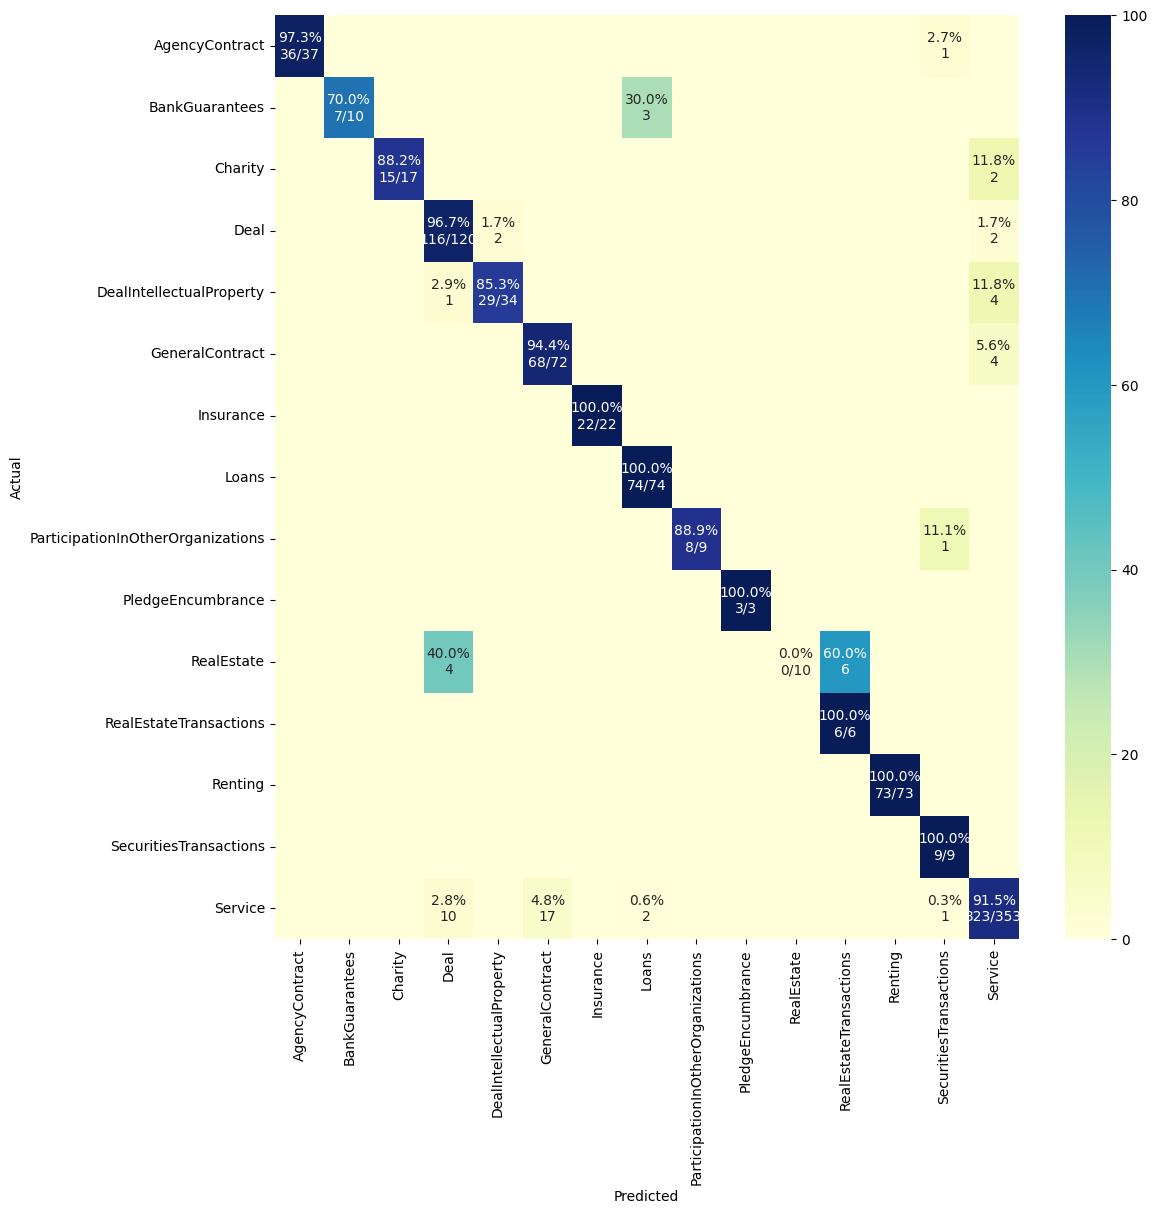

In [62]:
def make_report(umodel, subj_df):
  plot_cm(subj_df.subject_expected.values, subj_df.subject_predicted.values, figsize=(12, 12))
  
  img_path = umtm.reports_dir / f'subjects-confusion-matrix-{umodel.name}.png'
  plt.savefig(img_path, bbox_inches='tight')
  mlflow.log_artifact(img_path)

  report = classification_report(subj_df.subject_expected, subj_df.subject_predicted, digits=3)
  print(umodel.name)
  print(report)

  fn = umtm.reports_dir / f'subjects-classification_report-{umodel.name}.txt'
  with open(fn, "w") as text_file:
    text_file.write(report)
 
  mlflow.log_artifact(fn)


# subj_df = subj_df[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

In [63]:
print(active_mlflow_run.info)
mlflow.end_run()

<RunInfo: artifact_uri='mlflow-artifacts:/734503408361585659/3c1532785a684eaf9e5ca64110ea88e5/artifacts', end_time=None, experiment_id='734503408361585659', lifecycle_stage='active', run_id='3c1532785a684eaf9e5ca64110ea88e5', run_name='skillful-yak-923', run_uuid='3c1532785a684eaf9e5ca64110ea88e5', start_time=1678472969735, status='RUNNING', user_id='root'>
